In [1]:
import os
import random
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [5]:
import time
from datetime import datetime

In [6]:
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

In [7]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import torch_geometric.transforms as T
from torch_geometric import utils

In [8]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [9]:
%load_ext memory_profiler

In [10]:
import fasttext as ft

In [11]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

In [12]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stops = ENGLISH_STOP_WORDS.union({'new', 'line'})
signs = string.punctuation + '“' + '’' + '”' + '*'
punct_translator = str.maketrans('', '', signs)

In [13]:
from PyDictionary import PyDictionary
pydict = PyDictionary()

In [14]:
datalist = torch.load('../data/kp5DataList30-01-21.pt')

In [15]:
datalist2 = torch.load('../data/LH2DataList21-03-21.pt')

In [16]:
len(datalist), len(datalist2), 1877+2220

(1877, 2220, 4097)

In [17]:
def get_ngrams(x):
    ngrams = dict()
    #print(x.words)
    words = x.words[:-1]
    #print(words)
    ngrams[1] = words
    ngrams[2] = [words[i:i+2] for i in range(len(words)-1)]
    ngrams[3] = [words[i:i+3] for i in range(len(words)-2)]
    
    return ngrams

In [18]:
#datalist[:2], datalist2[:2]

In [19]:
df = pd.DataFrame([[i] for i in datalist], columns=['data_object'])
print(df.shape)
#df['ngrams'] = df.loc[:, 'data_object'].apply(get_ngrams)
df['ngrams'] = df.loc[:, 'data_object'].apply(lambda x: x.words[:-1])

(1877, 1)


In [20]:
df2 = pd.DataFrame([[i] for i in datalist2], columns=['data_object'])
#print(df2.shape)
#df['ngrams'] = df.loc[:, 'data_object'].apply(get_ngrams)
df2['ngrams'] = df2.loc[:, 'data_object'].apply(lambda x: x.words[:-1])

In [21]:
#df['clean_text'] = df.loc[:, 'data_object'].apply(lambda x: x.words[:-1])
df['clean_text'] = df.loc[:, 'data_object'].apply(lambda x: ' '.join(x.words[:-1]))

In [22]:
#df['clean_text'] = df.loc[:, 'data_object'].apply(lambda x: x.words[:-1])
df2['clean_text'] = df2.loc[:, 'data_object'].apply(lambda x: ' '.join(x.words[:-1]))

In [23]:
df.head(1)

,data_object,ngrams,clean_text
0,"[(a_left, [tensor([1., 0., 0., 0., 0., 0., 0.,...","[crowdsourcing, a, better, gmail, presentation...",crowdsourcing a better gmail presentation slid...


In [24]:
df2.head(1)

,data_object,ngrams,clean_text
0,"[(a_left, [tensor([1., 0., 0., 0., 0., 0., 0.,...","[16, google39s, new, priority, inbox, feature,...",16 google39s new priority inbox feature not on...


In [25]:
class Labeler:
    
    def __init__(self, row):
        row = row.values
        self.labels = row[0].labels
        self.ngrams = {key: row[1][key].copy() for key in row[1]}
        self.text = row[2]
        self.labeled = []

    def label_from_dict(self, label):
        if len(label) == 2:
            word = self.ngrams[1][label[0]]
        elif len(label) > 2:
            word = ' '.join([self.text[i] for i in label[:-1]])
        self.labeled.append((word, 1))    
    
    def clean_unlabeled(self, array: list):
        targets = list(zip(*self.labeled))[0]
        labels = []
        for item in array:
            if item[0] not in targets:
                word = item[0].split()
                if (word[0] not in stops) and (word[-1] not in stops):
                    labels.append(item)
        return labels
        
    def label_ngrams(self):
        for label in self.labels:
            self.label_from_dict(label)
        unlabeled = list(chain.from_iterable(self.ngrams.values()))
        unlabeled = [(' '.join(x), 0) if isinstance(x, list) else (x, 0)
                     for x in unlabeled]
        array = self.clean_unlabeled(unlabeled)
        self.labeled.extend(array)
        return self.labeled
    

def label_words(x):

    labels = list(chain.from_iterable(x.labels))
    words = x.words[:-1]
    
    labeled_words = [(words[i], 1) for i in labels if i != len(words)]
    positives = list(zip(*labeled_words))[0]
    #import pdb;pdb.set_trace()
    negatives = list({(w, 0) for w in words 
                      if (w not in positives) and (w not in stops)})
    labeled_words = list(set(labeled_words))
    labeled_words.extend(negatives)
    return labeled_words
    


In [26]:
%pdb on
df['word_labels'] = df.loc[:, 'data_object'].apply(label_words)

Automatic pdb calling has been turned ON


In [27]:
df2['word_labels'] = df2.loc[:, 'data_object'].apply(label_words)

In [28]:
%pdb off

Automatic pdb calling has been turned OFF


In [28]:
df2['len'] = df2.loc[:, 'ngrams'].apply(lambda x: len(x))

In [173]:
df['len'] = df.loc[:, 'ngrams'].apply(lambda x: len(x))

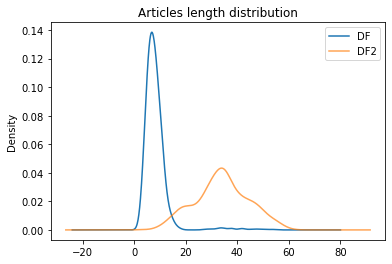

In [141]:
fig, ax = plt.subplots()
df['len'].plot.kde(ax=ax)
df2['len'].plot.kde(ax=ax, alpha=0.7)
plt.legend(['DF', 'DF2'])
plt.title('Articles length distribution');

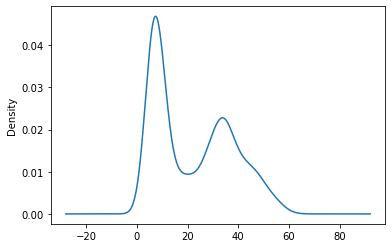

In [142]:
pd.concat([df['len'], df2['len']]).plot.kde();

In [31]:
vt = df2.loc[df2['len'] < 40].copy()
vt = vt.sample(frac=1.)
vt.shape, vt['clean_text'].duplicated().sum()

((1586, 5), 0)

In [32]:
size = 300
vt = vt.reset_index(drop=True)
valid_id = np.random.choice(vt.index, size=size)
test_id = np.setdiff1d(vt.index, valid_id)[:size]

In [33]:
valid = vt.loc[valid_id]
test = vt.loc[test_id]

### Oversampling inspired by GraphSMOTE

In [146]:
#%%writefile memscript.py
skipwords = {'cookies', 'united', 'todotxt',
                 'amazon', 'water', 'diy', 'george',
                 'henry'}
def clean_words(labeled_words):
    
    return [item for item in labeled_words 
            if (item[0] not in stops) and (not item[0].isnumeric())]

def oversample(labeled_words, min_add_size=2):

    #import pdb;pdb.set_trace()
    items = clean_words(labeled_words)
    
    #pos = [i[0] for i in clean_words 
    #       if (i[1] == 1) and (i[0] not in skipwords)]
    #if len(pos) == 0: return ''
    #neg_size = (len(clean_words) - len(pos))
    #add_size = 1
    #if len(pos) < neg_size:
    #    add_size = (len(clean_words) - 2*len(pos))//len(pos)
    #return [(i, add_size) for i in pos]
    
    positives = [i[0] for i in items if i[1] == 1]
    if len(positives) == 0:
        return ''
        #import pdb;pdb.set_trace()
        #kps = []
        #print(items)
        #in_ = ''
        #while in_ != 'q':
        #    kp = input('Enter an index of a keyword: ')
        #    kps.append(int(kp))
        #    in_ = input('Would you like to quit?')
        #positives = [items[k][0] for k in kps]
    add_size = max((len(items) - 2*len(positives))//len(positives), 0)
    if add_size != 0:
        for kw in positives:
            if kw not in skipwords:
                synonyms = pydict.synonym(kw)
                if synonyms:
                    nns = synonyms[:min(add_size, len(synonyms))]
                else:
                    nns = ft_model.get_nearest_neighbors(kw, k=add_size)
                    nns = list(zip(*nns))[1]                
                items.extend([(n, 1) for n in nns])
                del nns
    #del neighbours
    return items

In [174]:
df = df.reset_index(drop=True)

In [33]:
#from memscript import oversample

In [34]:
#%mprun -T OversampleMprof2 -f oversample [oversample(x) for x in arr]

In [35]:
%pdb on

Automatic pdb calling has been turned ON


In [40]:
%time df['oversampled'] = df.loc[:, 'word_labels'].apply(oversample)

gmail has no Synonyms in the API
airstrike has no Synonyms in the API
cnn has no Synonyms in the API
gmail has no Synonyms in the API
iphones has no Synonyms in the API
bittorrent has no Synonyms in the API
singletasking has no Synonyms in the API
firefox has no Synonyms in the API
craigslist has no Synonyms in the API
wakeonlan has no Synonyms in the API
dvr has no Synonyms in the API
favicons has no Synonyms in the API
firefox has no Synonyms in the API
prewindows has no Synonyms in the API
gmails has no Synonyms in the API
gmail has no Synonyms in the API
ubuntu has no Synonyms in the API
iphone has no Synonyms in the API
iphonetolaptop has no Synonyms in the API
boxee has no Synonyms in the API
linux has no Synonyms in the API
itunes has no Synonyms in the API
itunes has no Synonyms in the API
antivirus has no Synonyms in the API
keyloggers has no Synonyms in the API
wii has no Synonyms in the API
mozy has no Synonyms in the API
firefoxs has no Synonyms in the API
gmail has no Syno

In [193]:
%time valid['oversampled'] = valid.loc[:, 'word_labels'].apply(oversample)

youtube has no Synonyms in the API
greasemonkey has no Synonyms in the API
hdtv39s has no Synonyms in the API
windowsmac has no Synonyms in the API
distractionfree has no Synonyms in the API
mozilla39s has no Synonyms in the API
firefox has no Synonyms in the API
offline has no Synonyms in the API
inboxes has no Synonyms in the API
windowsmac has no Synonyms in the API
itunes has no Synonyms in the API
gmail has no Synonyms in the API
gmail has no Synonyms in the API
inbox has no Synonyms in the API
ios has no Synonyms in the API
itunes has no Synonyms in the API
bittorrent has no Synonyms in the API
windowsmaclinux has no Synonyms in the API
drm has no Synonyms in the API
apple39s has no Synonyms in the API
iphone has no Synonyms in the API
swype has no Synonyms in the API
vista39s has no Synonyms in the API
macworld has no Synonyms in the API
iphoto has no Synonyms in the API
lifehacker has no Synonyms in the API
vpn has no Synonyms in the API
gv has no Synonyms in the API
faceoff ha

In [42]:
df[['clean_text', 'word_labels', 'oversampled']].to_csv('../data/DFWithOversampledNodes.tsv', sep='\t')

In [194]:
valid[['clean_text', 'word_labels', 'oversampled']].to_csv('../data/ValidWithOversampledNodes.tsv', sep='\t')

In [195]:
#%pdb on
#def label_nodes(x):
#    lab = Labeler(x)
#    return lab.label_ngrams()#

#df['node_labels'] = df.apply(label_nodes, axis=1)

In [35]:
%pdb off

Automatic pdb calling has been turned OFF


In [43]:
#def labels_length(x):
#    lens = [len(i[0].split()) for i in x if i[1] == 1]
#    return lens
#
#df['labels_length'] = df.loc[:, 'node_labels'].apply(labels_length)
all_labels = list(chain.from_iterable(df['oversampled'].values.tolist()))
print(all_labels[:10])
labels_vocab = [i[0] for i in all_labels if i[1] == 1]
neg_vocab = [i[0] for i in all_labels if (i[1] == 0) and (i[0] not in labels_vocab)]
len(labels_vocab), len(neg_vocab), len(set(labels_vocab)), len(set(neg_vocab)),

[('gmail', 1), ('better', 1), ('presentation', 0), ('crowdsourcing', 0), ('slides', 0), ('notes', 0), ('netmail', 1), ('improved', 1), ('windows', 1), ('release', 0)]


(6422, 3743, 2249, 2176)

In [29]:
all_labels = list(chain.from_iterable(df['word_labels'].values.tolist()))
print(all_labels[:10])
labels_vocab = [i[0] for i in all_labels if i[1] == 1]
neg_vocab = [i[0] for i in all_labels if (i[1] == 0) and (i[0] not in labels_vocab)]
len(labels_vocab), len(neg_vocab), len(set(labels_vocab)), len(set(neg_vocab)),

[('better', 1), ('gmail', 1), ('slides', 0), ('crowdsourcing', 0), ('presentation', 0), ('notes', 0), ('windows', 1), ('operating', 0), ('release', 0), ('month', 0)]


(4355, 3963, 1272, 2295)

In [197]:
#def labels_length(x):
#    lens = [len(i[0].split()) for i in x if i[1] == 1]
#    return lens
#
#df['labels_length'] = df.loc[:, 'node_labels'].apply(labels_length)
valid_all_labels = list(chain.from_iterable(valid['oversampled'].values.tolist()))
print(valid_all_labels[:10])
valid_labels_vocab = [i[0] for i in valid_all_labels if i[1] == 1]
valid_neg_vocab = [i[0] for i in valid_all_labels if (i[1] == 0) and (i[0] not in valid_labels_vocab)]
len(valid_labels_vocab), len(valid_neg_vocab)

[('youtube', 1), ('greasemonkey', 1), ('video', 1), ('firefox', 0), ('web', 0), ('great', 0), ('hq', 0), ('simple', 0), ('bring', 0), ('highquality', 0)]


(3495, 3553)

In [34]:
valid_all_labels = list(chain.from_iterable(valid['word_labels'].values.tolist()))
print(valid_all_labels[:10])
valid_labels_vocab = [i[0] for i in valid_all_labels if i[1] == 1]
valid_neg_vocab = [i[0] for i in valid_all_labels if (i[1] == 0) and (i[0] not in valid_labels_vocab)]
len(valid_labels_vocab), len(valid_neg_vocab)

[('gmails', 1), ('inbox', 1), ('knew', 0), ('phone', 0), ('wanted', 0), ('hopes', 0), ('feature', 0), ('smart', 0), ('just', 0), ('say', 0)]


(718, 3976)

In [35]:
test_all_labels = list(chain.from_iterable(test['word_labels'].values.tolist()))
print(test_all_labels[:10])
test_labels_vocab = [i[0] for i in test_all_labels if i[1] == 1]
test_neg_vocab = [i[0] for i in test_all_labels if (i[1] == 0) and (i[0] not in test_labels_vocab)]
len(test_labels_vocab), len(test_neg_vocab)

[('students', 1), ('prime', 1), ('amazon', 1), ('that39s', 0), ('hitting', 0), ('got', 0), ('summer', 0), ('50', 0), ('free', 0), ('right', 0)]


(720, 3847)

In [36]:
#df = df.drop('word_labeles', axis=1)
df.head(1)

,data_object,ngrams,clean_text,word_labels
0,"[(a_left, [tensor([1., 0., 0., 0., 0., 0., 0.,...","[crowdsourcing, a, better, gmail, presentation...",crowdsourcing a better gmail presentation slid...,"[(better, 1), (gmail, 1), (slides, 0), (crowds..."


In [37]:
df.values[1]

array([Data(a_left=[9, 9], a_right=[9, 9], kp=[1], labels=[1], words=[9], x=[9, 100]),
       list(['windows', 'cloud', 'operating', 'system', 'release', 'within', 'a', 'month']),
       'windows cloud operating system release within a month',
       list([('windows', 1), ('operating', 0), ('release', 0), ('month', 0), ('cloud', 0)])],
      dtype=object)

In [190]:
ft_model.get_nearest_neighbors('windows')

[(0.9388589859008789, 'decwindows'),
 (0.9296922087669373, 'wxwindows'),
 (0.9087926745414734, 'openwindows'),
 (0.878109335899353, 'mswindows'),
 (0.8450111746788025, 'windowing'),
 (0.8273171782493591, 'microsoft'),
 (0.8271705508232117, 'desktops'),
 (0.8232629895210266, 'desktop'),
 (0.8161827921867371, 'macintoshes'),
 (0.7975568771362305, 'windowtext')]

In [40]:
#df = df.drop('word_labeles', axis=1)
df2.head(1)

,data_object,ngrams,clean_text,word_labels,len
0,"[(a_left, [tensor([1., 0., 0., 0., 0., 0., 0.,...","[16, google39s, new, priority, inbox, feature,...",16 google39s new priority inbox feature not on...,"[(google39s, 1), (inbox, 1), (feature, 0), (re...",26


In [177]:
len(all_labels), len(set(all_labels))

(10947, 4104)

### Word frequencies

In [178]:
pos_voc = pd.Series(labels_vocab)
neg_voc = pd.Series(neg_vocab)

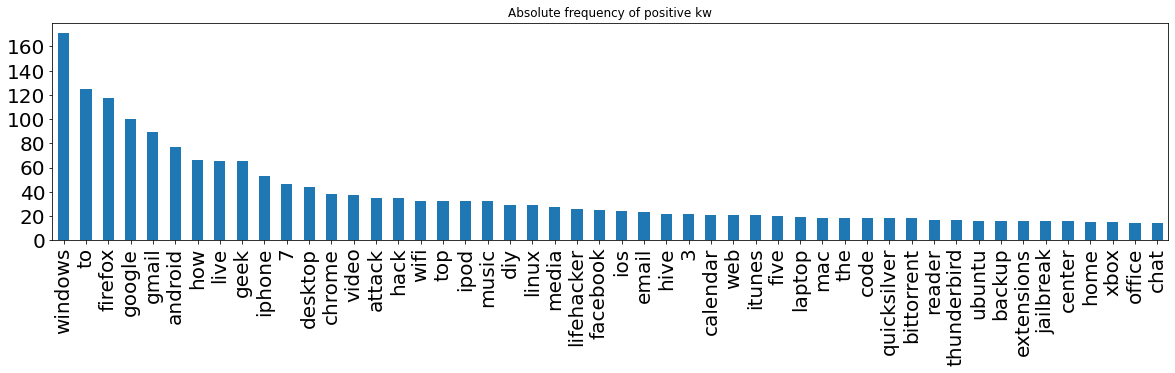

In [179]:
pos_voc.value_counts().nlargest(50).plot(kind='bar', figsize=(20, 4),
                                         fontsize=20,
                                         title='Absolute frequency of positive kw');

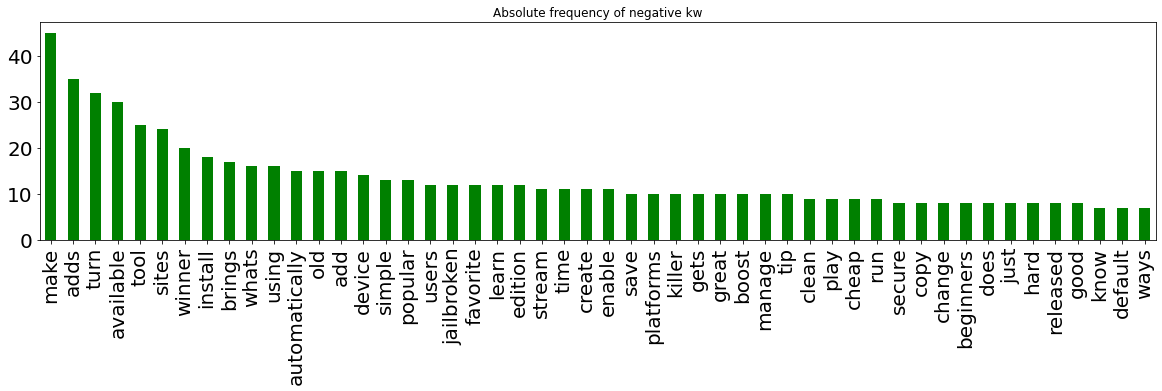

In [180]:
neg_voc.value_counts().nlargest(50).plot(kind='bar', figsize=(20, 4),
                                         fontsize=20,
                                         color='green',
                                         title='Absolute frequency of negative kw');

In [181]:
%%time
#labeled_vocabulary = df.explode('node_labels')['node_labels'].unique().tolist()
#vocabulary = list({i[0] for i in labeled_vocabulary})
#len(labeled_vocabulary), len(vocabulary)

'''Computing POS-tags for the words'''
def compute_pos(x):
    doc = nlp(x)
    return {t.text: t.pos_ for t in doc}

def compute_dep(x):
    doc = nlp(x)
    return {t.text: t.dep_ for t in doc}

df['pos'] = df.loc[:, 'clean_text'].apply(compute_pos)
df['dep'] = df.loc[:, 'clean_text'].apply(compute_dep)

CPU times: user 23.5 s, sys: 199 ms, total: 23.7 s
Wall time: 26.1 s


In [46]:
valid['pos'] = valid.loc[:, 'clean_text'].apply(compute_pos)
valid['dep'] = valid.loc[:, 'clean_text'].apply(compute_dep)

In [47]:
test['pos'] = test.loc[:, 'clean_text'].apply(compute_pos)
test['dep'] = test.loc[:, 'clean_text'].apply(compute_dep)

In [184]:
%pdb on
rows = df.values[:, 3:]
def tags_by_class(label, dict_id, vocab):
    tags = []
    for row in rows:
        for item in row[0]:
            if (item[1] == label) and (item[0] in vocab):
                try:
                    tags.append(row[dict_id][item[0]])
                except KeyError:
                    print(item[0], 'not found in', row[dict_id].keys())
    return tags

label_pos = pd.Series(tags_by_class(1, 2, labels_vocab))
neg_pos = pd.Series(tags_by_class(0, 2, neg_vocab))
label_dep = pd.Series(tags_by_class(1, 3, labels_vocab))
neg_dep = pd.Series(tags_by_class(0, 3, neg_vocab))

Automatic pdb calling has been turned ON
im not found in dict_keys(['chat', 'across', 'i', 'm', 'platforms', 'with', 'pidgin', '24'])
workspace—and not found in dict_keys(['clean', 'your', 'workspace', '—', 'and', 'keep', 'it', 'that', 'way'])
iphone—the not found in dict_keys(['forget', 'the', 'iphone', '—', 'ipod', 'touch', 'is', 'good', 'enough'])
im not found in dict_keys(['how', 'to', 'add', 'facebook', 'chat', 'your', 'i', 'm', 'client'])
3g not found in dict_keys(['improve', '3', 'g', 'modem', 'reception', 'with', 'a', 'kitchen', 'pot'])
im not found in dict_keys(['meebo', 'adds', 'video', 'and', 'voice', 'chat', 'to', 'webbased', 'i', 'm'])
iphone—only not found in dict_keys(['runkeeper', 'is', 'like', 'nike', 'for', 'your', 'iphone', '—', 'only', 'better'])
4g not found in dict_keys(['simple', 'root', 'unlocks', 'htc', 'evo', '4', 'g', 'in', 'one', 'click'])
im not found in dict_keys(['trillian', '5', 'goes', 'completely', 'free', 'brings', 'crossplatform', 'chat', 'log', 'and

In [185]:
len(label_pos), len(neg_pos), len(label_dep), len(neg_dep)

(4345, 3899, 4345, 3899)

### Tag frequencies

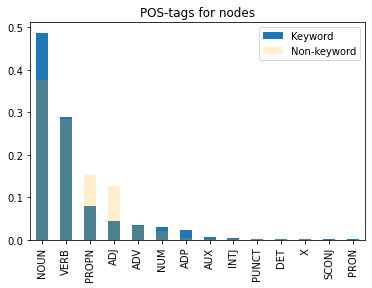

In [186]:
fig, ax = plt.subplots()
label_pos.value_counts(normalize=True).plot(kind='bar',
                              title='POS-tags for nodes',
                              ax=ax
                             )
neg_pos.value_counts(normalize=True).plot(kind='bar',
                            color='orange',
                            alpha=0.2,
                            ax=ax,
                            )
plt.legend(['Keyword', 'Non-keyword']);

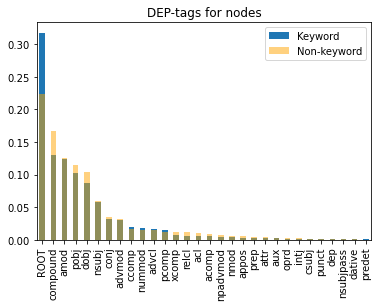

In [187]:
fig, ax = plt.subplots()
label_dep.value_counts(normalize=True).plot(kind='bar',
                              title='DEP-tags for nodes',
                              #alpha=0.5,
                              ax=ax
                             )
neg_dep.value_counts(normalize=True).plot(kind='bar',
                            color='orange',
                            alpha=0.5,
                            ax=ax,
                            )
plt.legend(['Keyword', 'Non-keyword']);

### FastText Embeddings

In [342]:
embwriter = SummaryWriter(log_dir='embeddings/')

In [336]:
%load_ext tensorboard

In [337]:
%pdb off

Automatic pdb calling has been turned OFF


In [38]:
ulabels_vocab = list(set(labels_vocab))
uneg_vocab = list(set(neg_vocab))
vectors = torch.stack([torch.tensor(ft_model[i]) for i in ulabels_vocab] + [torch.tensor(ft_model[i]) for i in uneg_vocab])
classes = [(w, 1) for w in ulabels_vocab] + [(w, 0) for w in uneg_vocab]
vectors.shape, len(classes)

(torch.Size([3567, 100]), 3567)

In [51]:
len(ulabels_vocab)+len(uneg_vocab)

4425

In [39]:
valid_ulabels_vocab = list(set(valid_labels_vocab))
valid_uneg_vocab = list(set(valid_neg_vocab))
valid_vectors = torch.stack([torch.tensor(ft_model[i]) for i in valid_ulabels_vocab] + [torch.tensor(ft_model[i]) for i in valid_uneg_vocab])
valid_classes = [(w, 1) for w in valid_ulabels_vocab] + [(w, 0) for w in valid_uneg_vocab]
valid_vectors.shape, len(valid_classes)

(torch.Size([2393, 100]), 2393)

In [40]:
test_ulabels_vocab = list(set(test_labels_vocab))
test_uneg_vocab = list(set(test_neg_vocab))
test_vectors = torch.stack([torch.tensor(ft_model[i]) for i in test_ulabels_vocab] + [torch.tensor(ft_model[i]) for i in test_uneg_vocab])
test_classes = [(w, 1) for w in test_ulabels_vocab] + [(w, 0) for w in test_uneg_vocab]
test_vectors.shape, len(test_classes)

(torch.Size([2470, 100]), 2470)

In [354]:
embwriter2 = SummaryWriter(log_dir='embeddings/LabeledWords2/')

In [355]:
embwriter2.add_embedding(vectors, metadata=classes, 
                        global_step=2, tag='ft_model_unique')

In [356]:
pos_vectors = torch.stack([torch.tensor(ft_model[i]) for i in ulabels_vocab])
neg_vectors = torch.stack([torch.tensor(ft_model[i]) for i in uneg_vocab])

for i in range(pos_vectors.size(1)):
    embwriter2.add_histogram('Positive Dimensions', pos_vectors[:, i], i)
for i in range(neg_vectors.size(1)):
    embwriter2.add_histogram('Negative Dimensions', neg_vectors[:, i], i)

In [358]:
df['clean_text'].unique().shape

(1876,)

In [537]:
dfc = df.copy()
dfc = dfc.explode('ngrams')
df.shape, df.shape[0]*0.7

((1877, 6), 1313.8999999999999)

### Creating a graph

In [55]:
len(classes), len(set(classes)), type(classes)

(4425, 4425, list)

In [59]:
#classes2[:5]
%pdb on

Automatic pdb calling has been turned ON


In [57]:
df['oversampled'] = df['oversampled'].apply(lambda x: tuple(x))

In [64]:
df.loc[df['oversampled'].str.len() < 1].shape, df.loc[df['oversampled'].isin(['', ' '])].shape

((15, 6), (0, 6))

In [65]:
dfc = df.loc[df['oversampled'].str.len() > 0].copy()

In [66]:
rows = []
array = set(dfc['oversampled'].values)
for row in array:
    s = list(zip(*row))[0]
    mask = [w[0] in s for w in classes]
    rows.append(mask)

In [42]:
rows = []
array = df['clean_text'].unique()
for row in array:
    s = row.lower()
    mask = [w[0] in s for w in classes]
    rows.append(mask)

In [43]:
docs = np.array(rows, dtype='float')
docs.sum(axis=0).min()

1.0

In [70]:
%pdb off

Automatic pdb calling has been turned OFF


In [240]:
valid['oversampled'] = valid['oversampled'].apply(lambda x: tuple(x))
validc = valid.loc[valid['oversampled'].str.len() > 0].copy()

In [241]:
valid_classes = list(set(chain.from_iterable(validc['oversampled'])))
len(valid_classes), len(set(valid_classes))

(4024, 4024)

In [242]:
valid_pos = [i[0] for i in valid_classes if i[1] == 1]
for i in range(len(valid_classes)):
    if (valid_classes[i][0] in valid_pos) and (valid_classes[i][0]):
        valid_classes[i] = (valid_classes[i][0], 1)

In [243]:
print(len(valid_classes), len(set(valid_classes)))
valid_classes = list(set(valid_classes))

4024 3745


In [244]:
valid_rows = []
valid_array = set(validc['oversampled'].values)
for row in valid_array:
    s = list(zip(*row))[0]
    mask = [w[0] in s for w in valid_classes]
    valid_rows.append(mask)

In [44]:
valid_rows = []
valid_array = valid['clean_text'].unique()
for row in valid_array:
    s = row.lower()
    mask = [w[0] in s for w in valid_classes]
    valid_rows.append(mask)

In [45]:
test_rows = []
test_array = test['clean_text'].unique()
for row in test_array:
    s = row.lower()
    mask = [w[0] in s for w in test_classes]
    test_rows.append(mask)

In [46]:
print(len(rows), len(rows[0]), len(classes))

1876 3567 3567


In [47]:
print(len(valid_rows), len(valid_rows[0]), len(valid_classes))

271 2393 2393


In [48]:
print(len(test_rows), len(test_rows[0]), len(test_classes))

300 2470 2470


In [49]:
#docs = np.array(rows, dtype='float')
matrix = np.matmul(docs.T, docs)

print(matrix.shape)

matrix[matrix > 1] = 1
np.fill_diagonal(matrix, 0)
dm = pd.DataFrame(matrix, columns=classes, index=classes)

(3567, 3567)


In [50]:
valid_docs = np.array(valid_rows, dtype='float')
valid_matrix = np.matmul(valid_docs.T, valid_docs)

print(valid_matrix.shape)

valid_matrix[valid_matrix > 1] = 1
np.fill_diagonal(valid_matrix, 0)
valid_dm = pd.DataFrame(valid_matrix, columns=valid_classes, index=valid_classes)

(2393, 2393)


In [51]:
test_docs = np.array(test_rows, dtype='float')
test_matrix = np.matmul(test_docs.T, test_docs)

print(test_matrix.shape)

test_matrix[test_matrix > 1] = 1
np.fill_diagonal(test_matrix, 0)
test_dm = pd.DataFrame(test_matrix, columns=test_classes, index=test_classes)

(2470, 2470)


In [52]:
dm.sum(axis=1)[dm.sum(axis=1) == 0]

Series([], dtype: float64)

In [53]:
test_dm.sum(axis=1)[test_dm.sum(axis=1) == 0]

Series([], dtype: float64)

In [54]:
valid_dm.sum(axis=1)[valid_dm.sum(axis=1) == 0]

Series([], dtype: float64)

In [55]:
def get_edges(words, data):
    edges = []
    for w in words:
        neighbours = data.loc[data.loc[w] == 1].index.tolist()
        edges.extend(list(zip([w]*len(neighbours), neighbours)))
        
    return edges

In [56]:
import networkx as nx

In [57]:
dm.columns.shape, dm.columns[:5]

((3567,),
 Index([('content', 1), ('gallery', 1), ('cleaning', 1), ('bad', 1),
        ('account', 1)],
       dtype='object'))

In [69]:
%pdb on

Automatic pdb calling has been turned ON


In [58]:
nodes = [i[0] for i in dm.columns]
nodes_labels = [i[1] for i in dm.columns]

In [59]:
valid_nodes = [i[0] for i in valid_dm.columns]
valid_nodes_labels = [i[1] for i in valid_dm.columns]

In [60]:
test_nodes = [i[0] for i in test_dm.columns]
test_nodes_labels = [i[1] for i in test_dm.columns]

In [61]:
G = nx.Graph()
G.add_nodes_from(nodes)

In [62]:
Gvalid = nx.Graph()
Gvalid.add_nodes_from(valid_nodes)

In [63]:
Gtest = nx.Graph()
Gtest.add_nodes_from(test_nodes)

In [64]:
G.nodes['kevin']

{}

In [65]:
dm.columns = nodes
dm.index = nodes
dm.head()

,content,gallery,cleaning,bad,account,mcqueen,virtualdesktop,early,3,magazines,...,index,long,faces,subject,disasters,months,favicon,arab,hat,host
content,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gallery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
cleaning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
bad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
account,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
valid_dm.columns = valid_nodes
valid_dm.index = valid_nodes
valid_dm.head()

,album,history,content,financebased,quicktime,quotdiy,cleaning,office,pages,video,...,conversation,disabled,36,stomach,jailbreak,connect,months,favicon,night,set
album,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
history,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
content,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
financebased,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quicktime,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
test_dm.columns = test_nodes
test_dm.index = test_nodes
test_dm.head()

,album,exploit,images,gadgets,energy,739s,cleaning,lastpass,gtdgmail,video,...,finder,long,mild,surfaces,quotsoonquot,subject,connect,suw,applauncherandthensome,set
album,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
exploit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gadgets,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
test_dm.to_csv('../data/TestDMGraphAdj.tsv', sep='\t')

In [81]:
dm.shape
dm.to_csv('../data/DMGraphAdj.tsv', sep='\t')

In [68]:
%%time
edges = get_edges(nodes, dm)
G.add_edges_from(edges)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [69]:
valid_dm.index.shape, valid_dm.index.unique().shape

((2393,), (2393,))

In [70]:
%%time
valid_edges = get_edges(valid_nodes, valid_dm)
Gvalid.add_edges_from(valid_edges)

CPU times: user 2.17 s, sys: 41.3 ms, total: 2.21 s
Wall time: 2.2 s


In [71]:
%%time
test_edges = get_edges(test_nodes, test_dm)
Gtest.add_edges_from(test_edges)

CPU times: user 2.42 s, sys: 114 ms, total: 2.53 s
Wall time: 2.54 s


In [72]:
nx.is_connected(G), nx.is_connected(Gvalid), nx.is_connected(Gtest) 

(True, True, True)

In [73]:
labeled_vocabulary = dict(zip(nodes, nodes_labels))

In [74]:
valid_labeled_vocabulary = dict(zip(valid_nodes, valid_nodes_labels))

In [75]:
test_labeled_vocabulary = dict(zip(test_nodes, test_nodes_labels))

In [76]:
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

In [86]:
%pdb off

Automatic pdb calling has been turned OFF


In [77]:
attrs = {n: {"text": n,
             "degree": G.degree[n], 
             'label': labeled_vocabulary[n],
             'colour': 'red' if labeled_vocabulary[n] == 1 else 'lightskyblue',
             'x': ft_model[n]} 
         for n in G.nodes}

nx.set_node_attributes(G, attrs)

In [78]:
valid_attrs = {n: {"text": n,
             "degree": Gvalid.degree[n], 
             'label': valid_labeled_vocabulary[n],
             'colour': 'red' if valid_labeled_vocabulary[n] == 1 else 'lightskyblue',
             'x': ft_model[n]} 
         for n in Gvalid.nodes}

nx.set_node_attributes(Gvalid, valid_attrs)

In [79]:
test_attrs = {n: {"text": n,
             "degree": Gtest.degree[n], 
             'label': test_labeled_vocabulary[n],
             'colour': 'red' if test_labeled_vocabulary[n] == 1 else 'lightskyblue',
             'x': ft_model[n]} 
         for n in Gtest.nodes}

nx.set_node_attributes(Gtest, test_attrs)

In [80]:
def show_bokeh(G, params, filename, colorfill='colour'):
    plot = Plot(plot_width=1500, plot_height=1000,
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = "Graph Interaction Demonstration"

    node_hover_tool = HoverTool(tooltips=[*params])
    plot.add_tools(
        node_hover_tool, 
        BoxZoomTool(), 
        ResetTool()
    )

    graph_renderer = from_networkx(G, nx.spring_layout, 
                                   scale=1, center=(0, 0))

    graph_renderer.node_renderer.glyph = Circle(
        size=15, 
        #fill_color=Spectral4[0]
        fill_color='colour'
    )
    #graph_renderer.edge_renderer.glyph = MultiLine(
    #    line_color="edge_color", 
    #    line_alpha=0.8, 
    #    line_width=1
    #)
    plot.renderers.append(graph_renderer)

    output_file("../plots/{}.html".format(filename))
    show(plot)

In [89]:
params = [('text', '@text'), ('label', '@label')]
filename = 'UnigramsGraphOversampled'
show_bokeh(G, params, filename, colorfill='colour')

In [576]:
params = [('text', '@text'), ('label', '@label')]
filename = 'UnigramsGraph2'
show_bokeh(G2, params, filename, colorfill='colour')

In [77]:
nx.is_connected(Gtest)#nx.is_connected(G), nx.is_connected(Gvalid), 

True

In [116]:
subgraph = max(nx.connected_components(G), key=len)
G = G.subgraph(subgraph)
nx.is_connected(G)

True

### Computing centrality metrics

In [117]:
%time cent_degree = nx.degree_centrality(G)

CPU times: user 91.4 ms, sys: 0 ns, total: 91.4 ms
Wall time: 89.7 ms


In [118]:
%time cent_eigen = nx.eigenvector_centrality(G)

CPU times: user 2.85 s, sys: 0 ns, total: 2.85 s
Wall time: 2.86 s


In [119]:
%time cent_closeness = nx.closeness_centrality(G)

CPU times: user 3min 43s, sys: 12.4 ms, total: 3min 43s
Wall time: 3min 43s


In [120]:
%time cent_between = nx.betweenness_centrality(G)

CPU times: user 5min 20s, sys: 3.55 ms, total: 5min 20s
Wall time: 5min 20s


In [121]:
%time cent_voterank = nx.voterank(G)

CPU times: user 7min 41s, sys: 0 ns, total: 7min 41s
Wall time: 7min 41s


In [123]:
index = G.nodes
data = [
    [labeled_vocabulary[i], cent_degree[i], cent_eigen[i], cent_closeness[i], cent_between[i]]
    for i in index
]
columns = ['label', 'cent_degree', 'cent_eigen', 'cent_closeness', 'cent_between']
cent_df = pd.DataFrame(data, index=index, columns=columns)

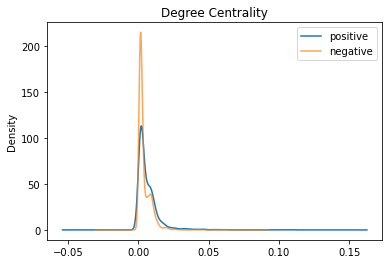

In [124]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['label'] == 1]['cent_degree'].plot.kde(ax=ax)
cent_df.loc[cent_df['label'] == 0]['cent_degree'].plot.kde(ax=ax, alpha=0.7)
plt.legend(['positive', 'negative'])
plt.title('Degree Centrality');

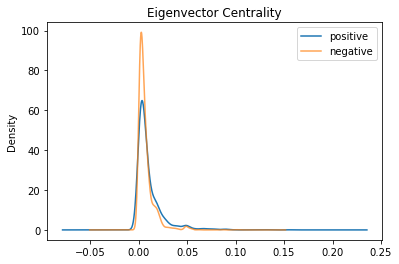

In [125]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['label'] == 1]['cent_eigen'].plot.kde(ax=ax)
cent_df.loc[cent_df['label'] == 0]['cent_eigen'].plot.kde(ax=ax, alpha=0.7)
plt.legend(['positive', 'negative'])
plt.title('Eigenvector Centrality');

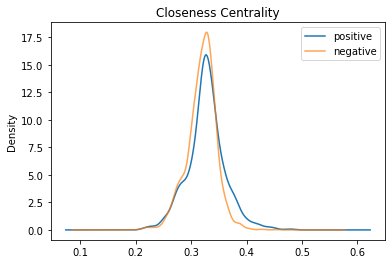

In [126]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['label'] == 1]['cent_closeness'].plot.kde(ax=ax)
cent_df.loc[cent_df['label'] == 0]['cent_closeness'].plot.kde(ax=ax, alpha=0.7)
plt.legend(['positive', 'negative'])
plt.title('Closeness Centrality');

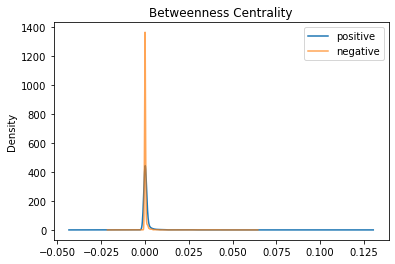

In [127]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['label'] == 1]['cent_between'].plot.kde(ax=ax)
cent_df.loc[cent_df['label'] == 0]['cent_between'].plot.kde(ax=ax, alpha=0.7)
plt.legend(['positive', 'negative'])
plt.title('Betweenness Centrality');

In [130]:
cent_df['label'].value_counts()[0]

2170

In [131]:
voterank = [(i, labeled_vocabulary[i])for i in cent_voterank]
vr = pd.DataFrame(voterank, columns=['node', 'label'])
vr0 = (vr['label'] == 0).sum()/cent_df['label'].value_counts()[0]
vr1 = (vr['label'] == 1).sum()/cent_df['label'].value_counts()[1]
vr0, vr1, (vr['label'] == 0).sum(), (vr['label'] == 1).sum()

(0.45806451612903226, 0.8485663082437276, 994, 1894)

### Training the model

In [81]:
graph_data = pyg_utils.from_networkx(G)
graph_data

Data(colour=[3567], degree=[3567], edge_index=[2, 312496], label=[3567], text=[3567], x=[3567, 100])

In [82]:
graph_valid = pyg_utils.from_networkx(Gvalid)
graph_valid

Data(colour=[2393], degree=[2393], edge_index=[2, 231726], label=[2393], text=[2393], x=[2393, 100])

In [260]:
graph_valid.label[graph_valid.label == 1].shape, graph_valid.label[graph_valid.label == 0].shape

(torch.Size([1875]), torch.Size([1870]))

In [83]:
graph_test = pyg_utils.from_networkx(Gtest)
graph_test

Data(colour=[2470], degree=[2470], edge_index=[2, 227324], label=[2470], text=[2470], x=[2470, 100])

In [79]:
#torch.save(graph_data, '../data/1graph_datakp5DataList.pt')
#torch.save(graph_valid, '../data/1Validgraph_dataLH2DataList.pt')
torch.save(graph_test, '../data/1Testgraph_dataLH2DataList.pt')

In [14]:
#train_size = int(graph_data.x.size(0)*0.7)
#test_size = int(graph_data.x.size(0)*0.1)
#val_size = graph_data.x.size(0) - (train_size + test_size)
#train_mask = torch.tensor([True]*train_size + [False]*(test_size + val_size))
#val_mask = torch.tensor([False]*train_size + [True]*val_size + [False]*test_size)
#test_mask = torch.tensor([False]*(train_size + val_size) + [True]*test_size)

In [15]:
#print(train_mask.shape, val_mask.shape, test_mask.shape)
#torch.where(train_mask), torch.where(val_mask), torch.where(test_mask)

In [16]:
#graph_data.train_mask = train_mask
#graph_data.val_mask = val_mask
#graph_data.test_mask = test_mask
#graph_data

In [84]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, 
                 output_dim, dropout=0.25,
                 gcn_dropout=None,
                 nconvs=3, conv_layer=pyg_nn.GCNConv,
                 aggr='add', 
                 flow='source_to_target',
                 weight=torch.tensor([1, 1])):
        
        super(GNNStack, self).__init__()
        self.conv = conv_layer
        self.dropout = dropout
        self.gcn_dropout = gcn_dropout
        self.num_layers = nconvs
        self.class_weight = weight
        
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim, 
                                                aggr, flow))
        self.lns = nn.ModuleList()
        #for i in range(nconvs):
        #    self.lns.append(nn.LayerNorm(hidden_dim))

        for l in range(self.num_layers-1):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim, 
                                                    aggr, flow))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, output_dim),
        )

    def build_conv_model(self, input_dim, hidden_dim, aggr, flow):
        return self.conv(input_dim, hidden_dim, aggr=aggr, flow=flow)

    def forward(self, data, training=True):
        x, edge_index = data.x, data.edge_index
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            if self.gcn_dropout:
                x = F.dropout(x, p=self.gcn_dropout, training=training)
            #if not i == self.num_layers - 1:
            #    x = self.lns[i](x)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        #print('Got it')
        return F.nll_loss(pred, label, 
                          weight=self.class_weight)

In [85]:
'''Adding a function to get accuracy'''
def get_accuracy(preds, targets):
    
    preds = preds.argmax(dim=1)
    ncorrects = preds.eq(targets).sum().item()
    return ncorrects / len(targets)

In [116]:
train_ds = torch.load('../data/1graph_datakp5DataListOversampled.pt')
valid_ds = torch.load('../data/1Validgraph_dataLH2DataListOversampled.pt')
test_ds = graph_test#torch.load('../data/1Testgraph_dataLH2DataList.pt')

In [87]:
sum([i == 1 for i in train_ds.label]), sum([i == 0 for i in train_ds.label])

(tensor(1272), tensor(2295))

In [88]:
sum([i == 1 for i in valid_ds.label]), sum([i == 0 for i in valid_ds.label])

(tensor(356), tensor(2037))

In [93]:
%pdb off

Automatic pdb calling has been turned OFF


In [128]:
def train_node_clf(train, valid, 
                   epochs,
                   hidden_dim,
                   conv_type,
                   aggr,
                   #writer,
                   flow='source_to_target',
                   heads=1,
                   dropout=0.25,
                   gcn_dropout=0.25,
                   optimiser=optim.Adam,
                   verbose=False,
                   lr=3e-5,
                   class_weight=torch.tensor([1., 1.])):
    
    dim = train.x.shape[1]
    model = GNNStack(dim, hidden_dim, 2, 
                     dropout=dropout,
                     gcn_dropout=gcn_dropout,
                     nconvs=heads,
                     conv_layer=conv_type,
                     aggr=aggr,
                     flow=flow,
                     weight=class_weight,
                    )
    
    opt = optimiser(model.parameters(), lr=lr)
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    train_label = train.label
    valid_label = valid.label
    
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        embedding, train_pred = model(train, training=True)
        #writer.add_histogram('convs.0.weight', 
        #                     dict(model.named_parameters())['convs.0.weight'],
        #                    epoch)
        #writer.add_histogram('convs.1.weight', 
        #                     dict(model.named_parameters())['convs.1.weight'],
        #                    epoch)
        #writer.add_histogram('convs.2.weight', 
        #                     dict(model.named_parameters())['convs.2.weight'],
        #                    epoch)
        #if epoch != 0:
        #    writer.add_histogram('convs.2.weight Gradients', 
        #                         dict(model.named_parameters())['convs.2.weight'].grad,
        #                        epoch)
        #    writer.add_histogram('post_mp.2.weight Gradients', 
        #                         dict(model.named_parameters())['post_mp.2.weight'].grad,
        #                        epoch)
        train_loss = model.loss(train_pred, train_label)
        train_loss.backward()
        opt.step()
        train_acc = get_accuracy(train_pred, train_label)
        train_losses.append(train_loss.item())
        train_accuracies.append(train_acc)
        
        #with torch.no_grad():
        #    model.eval()
        #    valid_embedding, valid_pred = model(valid, training=False)
        #    valid_loss = model.loss(valid_pred, valid_label)
        #    valid_acc = get_accuracy(valid_pred, valid_label)
        #    valid_losses.append(valid_loss.item())
        #    valid_accuracies.append(valid_acc)
        
        if verbose:
            print('Epoch', epoch)
            print('Training Loss', train_loss.item())
            print('Training Accuracy', train_acc)
            #print('Validation Loss', valid_loss.item())
            #print('Validation Accuracy', valid_acc)
            print('#########################################################')
        


    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [129]:
%%time 
epochs = 400
hidden_dim = 200
conv_type = pyg_nn.TransformerConv
aggr = 'add'
flow = 'source_to_target'
heads = 3
dropout = 0.5
gcn_dropout = 0.5
optimiser = optim.Adam
verbose = True
lr = 2e-4
class_weight = torch.tensor([1., 1.])
net, train_losses, train_accs, valid_losses, valid_accs = train_node_clf(
    #graph_data,
    train_ds,
    train_ds,
    epochs, 
    hidden_dim,
    conv_type=conv_type,
    aggr=aggr,
    flow=flow,
    heads=heads,
    dropout=dropout,
    optimiser=optimiser,
    lr=lr,
    verbose=verbose,
    class_weight=class_weight,
)

Epoch 0
Training Loss 0.6951614618301392
Training Accuracy 0.49454793275783737
#########################################################
Epoch 1
Training Loss 0.6948332190513611
Training Accuracy 0.49886415265788275
#########################################################
Epoch 2
Training Loss 0.6934030055999756
Training Accuracy 0.5018173557473875
#########################################################
Epoch 3
Training Loss 0.6935195326805115
Training Accuracy 0.506133575647433
#########################################################
Epoch 4
Training Loss 0.6928786635398865
Training Accuracy 0.5095411176737846
#########################################################
Epoch 5
Training Loss 0.6927970051765442
Training Accuracy 0.5077237619263971
#########################################################
Epoch 6
Training Loss 0.6919621229171753
Training Accuracy 0.5168105406633349
#########################################################
Epoch 7
Training Loss 0.6923808455467224
Traini

Visualising the losses and accuracies.

In [1]:
#plt.plot(range(epochs), train_losses)
#plt.plot(range(epochs), valid_losses, color='red')
#plt.title('Losses')
#plt.legend(['train', 'validation']);
#plt.savefig('../plots/GATLosses{}.png'.format(datetime.today()));

In [2]:
#plt.plot(range(epochs), train_accs)
#plt.plot(range(epochs), valid_accs, color='red')
#plt.title('Accuracies')
#plt.legend(['train', 'validation']);
#plt.savefig('../plots/GATAccuracies{}.png'.format(datetime.today()));

In [114]:
%%time
embedding, test_pred = net(test_ds, training=False)
test_label = test_ds.label
test_loss = net.loss(test_pred, test_label)
test_acc = get_accuracy(test_pred, test_label)
print(test_loss)
print(test_acc)

tensor(0.8190, grad_fn=<NllLossBackward>)
0.2805668016194332
CPU times: user 1.47 s, sys: 165 ms, total: 1.64 s
Wall time: 825 ms


In [115]:
print(classification_report(test_label, test_pred.argmax(1))) '''GAT Imbalanced Data'''

              precision    recall  f1-score   support

           0       0.95      0.16      0.28      2103
           1       0.17      0.95      0.28       367

    accuracy                           0.28      2470
   macro avg       0.56      0.56      0.28      2470
weighted avg       0.83      0.28      0.28      2470



In [89]:
%%time
embedding, train_pred = net(train_ds, training=False)
train_label = train_ds.label
train_loss = net.loss(train_pred, train_label)
train_acc = get_accuracy(train_pred, train_label)
print(train_loss)
print(train_acc)

tensor(0.3873, grad_fn=<NllLossBackward>)
0.8452975920036347
CPU times: user 783 ms, sys: 95.6 ms, total: 878 ms
Wall time: 220 ms


In [90]:
print(classification_report(train_label, train_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2170
           1       0.84      0.87      0.85      2232

    accuracy                           0.85      4402
   macro avg       0.85      0.85      0.85      4402
weighted avg       0.85      0.85      0.85      4402



In [130]:
%%time
embedding, valid_pred = net(valid_ds, training=False)
valid_label = valid_ds.label
valid_loss = net.loss(valid_pred, valid_label)
valid_acc = get_accuracy(valid_pred, valid_label)
print(valid_loss)
print(valid_acc)

tensor(1.0445, grad_fn=<NllLossBackward>)
0.6955941255006676
CPU times: user 6.7 s, sys: 942 ms, total: 7.64 s
Wall time: 3.14 s


In [131]:
print(classification_report(valid_label, valid_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1870
           1       0.67      0.76      0.71      1875

    accuracy                           0.70      3745
   macro avg       0.70      0.70      0.69      3745
weighted avg       0.70      0.70      0.69      3745



### Visualising errors on the test graph

In [93]:
Gtest

In [105]:
cdict = dict(zip(test_ds.text, zip(test_label.tolist(), test_pred.argmax(1).tolist())))

In [108]:
test_attrs = {n: {"text": n,
             "degree": Gtest.degree[n], 
             'label': test_labeled_vocabulary[n],
             'colour': 'red' if len(set(cdict[n])) == 2 else 'green',
             'x': ft_model[n]} 
         for n in Gtest.nodes}

nx.set_node_attributes(Gtest, test_attrs)

In [113]:
Gtest.nodes['bookmarks']

{'text': 'bookmarks',
 'degree': 80,
 'label': 1,
 'colour': 'green',
 'x': array([-0.10288477,  0.04339846,  0.45202053, -0.5082762 ,  0.07505745,
         0.4930952 ,  0.22593859, -0.27250767, -0.30209467, -0.2545395 ,
         0.44719356, -0.14187859, -0.7718823 ,  0.5743875 , -0.8588605 ,
        -0.16661246, -0.34453103,  0.6001299 ,  0.08255415, -0.22060111,
        -0.22824895,  0.3138491 ,  0.19341873, -0.40819907, -0.49947572,
        -0.00939848,  0.01349518, -0.0938243 ,  0.45880097, -0.02785795,
        -0.23714228, -0.50641143,  0.5417998 ,  0.37112734, -0.2578697 ,
        -0.00875674, -0.26523054,  0.45684624, -0.01209025,  0.28152984,
         0.19770914,  0.6452087 ,  0.21547554,  0.34498647,  0.43015164,
        -0.24489239,  0.5258978 ,  0.20650665, -0.09813168,  0.04287248,
         0.23168558, -0.11473263,  0.08418909, -0.5156996 ,  0.14731653,
        -0.40773335,  0.13302988,  0.40058702,  0.18123774,  0.14356004,
        -0.12806197, -0.05587502,  0.18033889, -0

In [114]:
params = [('text', '@text'), ('label', '@label')]
filename = 'TestGraphPredsRedIsWrong'
#show_bokeh(Gtest, params, filename, colorfill='colour')

#### Computing graph metrics to analyse the difference between correctly and wrongly classified instances

In [116]:
%time cent_degree = nx.degree_centrality(Gtest)

CPU times: user 442 µs, sys: 4.08 ms, total: 4.52 ms
Wall time: 4.42 ms


In [117]:
%time cent_eigen = nx.eigenvector_centrality(Gtest)

CPU times: user 551 ms, sys: 210 µs, total: 551 ms
Wall time: 549 ms


In [118]:
%time cent_closeness = nx.closeness_centrality(Gtest)

CPU times: user 3.09 s, sys: 3.55 ms, total: 3.09 s
Wall time: 3.1 s


In [119]:
%time cent_between = nx.betweenness_centrality(Gtest)

CPU times: user 1min 19s, sys: 25.5 ms, total: 1min 19s
Wall time: 1min 19s


In [120]:
#%time cent_voterank = nx.voterank(G)

In [122]:
index = Gtest.nodes
data = [
    [cdict[i][0], cdict[i][1], cent_degree[i], cent_eigen[i], cent_closeness[i], cent_between[i]]
    for i in index
]
columns = ['true', 'pred', 'cent_degree', 'cent_eigen', 'cent_closeness', 'cent_between']
cent_df = pd.DataFrame(data, index=index, columns=columns)

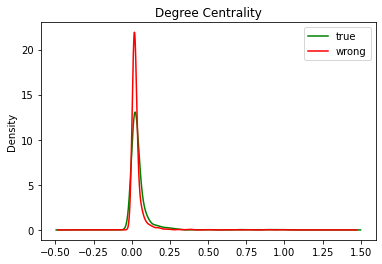

In [126]:
cent_df['correct'] = cent_df['true'] == cent_df['pred']
fig, ax = plt.subplots()
cent_df.loc[cent_df['correct']]['cent_degree'].plot.kde(color='green', ax=ax)
cent_df.loc[cent_df['correct'] == False]['cent_degree'].plot.kde(color='red', ax=ax)
plt.legend(['true', 'wrong'])
plt.title('Degree Centrality');

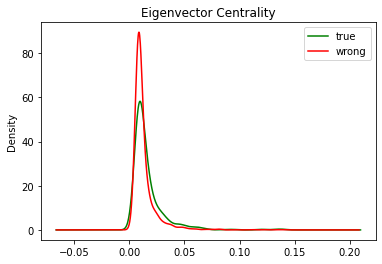

In [127]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['correct']]['cent_eigen'].plot.kde(color='green', ax=ax)
cent_df.loc[cent_df['correct'] == False]['cent_eigen'].plot.kde(color='red', ax=ax)
plt.legend(['true', 'wrong'])
plt.title('Eigenvector Centrality');

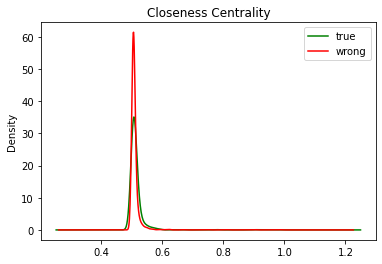

In [128]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['correct']]['cent_closeness'].plot.kde(color='green', ax=ax)
cent_df.loc[cent_df['correct'] == False]['cent_closeness'].plot.kde(color='red', ax=ax)
plt.legend(['true', 'wrong'])
plt.title('Closeness Centrality');

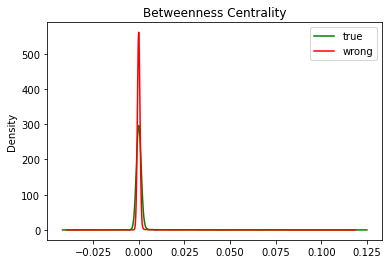

In [129]:
fig, ax = plt.subplots()
cent_df.loc[cent_df['correct']]['cent_between'].plot.kde(color='green', ax=ax)
cent_df.loc[cent_df['correct'] == False]['cent_between'].plot.kde(color='red', ax=ax)
plt.legend(['true', 'wrong'])
plt.title('Betweenness Centrality');

In [130]:
cent_df = cent_df.reset_index()

In [138]:
cent_df.loc[~cent_df['correct']][['index', 'true', 'pred']].values[:50]

array([['sick', 1, 0],
       ['timer', 1, 0],
       ['bills', 1, 0],
       ['off', 1, 0],
       ['featured', 1, 0],
       ['fold', 1, 0],
       ['wack', 1, 0],
       ['lists', 1, 0],
       ['tsunami', 1, 0],
       ['japan', 1, 0],
       ['if', 1, 0],
       ['saving', 1, 0],
       ['kids', 1, 0],
       ['day', 1, 0],
       ['quibi', 1, 0],
       ['to', 1, 0],
       ['keepass', 1, 0],
       ['hours', 1, 0],
       ['twin', 1, 0],
       ['quetzalquot', 1, 0],
       ['asleep', 1, 0],
       ['shield', 1, 0],
       ['7', 1, 0],
       ['how', 1, 0],
       ['five', 1, 0],
       ['you', 1, 0],
       ['assistant', 1, 0],
       ['after', 1, 0],
       ['machine', 1, 0],
       ['panel', 1, 0],
       ['launching', 1, 0],
       ['coups', 1, 0],
       ['dear', 1, 0],
       ['boomerang', 1, 0],
       ['galaxy', 1, 0],
       ['prime', 1, 0],
       ['status', 0, 1],
       ['housekeeper', 0, 1],
       ['abroad', 0, 1],
       ['servers', 0, 1],
       ['purity', 0, 1],

In [140]:
cent_df.loc[cent_df['correct']][['index', 'true', 'pred']].values[50:100]

array([['file', 1, 1],
       ['instant', 1, 1],
       ['jeopardys', 1, 1],
       ['food', 1, 1],
       ['tray—so', 1, 1],
       ['dropbox', 1, 1],
       ['filesyncing', 1, 1],
       ['challenge', 1, 1],
       ['wifi', 1, 1],
       ['metadata', 1, 1],
       ['backup', 1, 1],
       ['mode', 1, 1],
       ['desktops—applications', 1, 1],
       ['cooling', 1, 1],
       ['kitchen', 1, 1],
       ['word', 1, 1],
       ['healthy', 1, 1],
       ['gps', 1, 1],
       ['windows39', 1, 1],
       ['linux', 1, 1],
       ['firefox39s', 1, 1],
       ['windowsmaclinux', 1, 1],
       ['fans', 1, 1],
       ['internet', 1, 1],
       ['leopard', 1, 1],
       ['repeater', 1, 1],
       ['mac', 1, 1],
       ['wep', 1, 1],
       ['cds—that', 1, 1],
       ['chrome', 1, 1],
       ['pdfs', 1, 1],
       ['pvr', 1, 1],
       ['dvr', 1, 1],
       ['feature', 1, 1],
       ['communication', 1, 1],
       ['tips', 1, 1],
       ['hardware—has', 1, 1],
       ['productivity', 1, 1],
     

In [141]:
def get_pos(word):
    doc = nlp(word)
    return [t.pos_ for t in doc]

cent_df['pos_tags'] = cent_df.loc[:, 'index'].apply(get_pos)

In [142]:
cent_df = cent_df.explode('pos_tags')

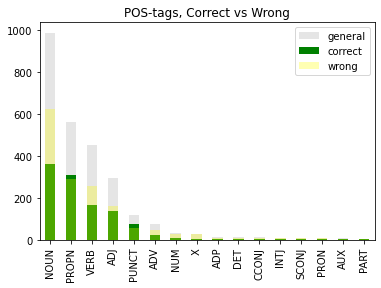

In [155]:
fig, ax = plt.subplots()

cent_df['pos_tags'].value_counts().plot(kind='bar', color='black', alpha=0.1, ax=ax)
cent_df.loc[cent_df['correct']]['pos_tags'].value_counts().plot(kind='bar', color='green', ax=ax)
cent_df.loc[~cent_df['correct']]['pos_tags'].value_counts().plot(kind='bar', color='yellow', 
                                                                 ax=ax, alpha=0.3)
plt.legend(['general', 'correct', 'wrong'])
plt.title('POS-tags, Correct vs Wrong');

### Some conclusions after the brief error analysis

* Node metrics seem to be very similar, there is almost no difference between correctly and wrongly predicted instances. Maybe this is the reason the model was not so accurate
* From the plot above: it seems to be a bit easier to classify correctly proper nouns. Nouns, verbs and adjectives can both be a keyphrase and a non-keyphrase